# Machine Learning - Practical 4 - Deep Learning VS Trees


Names: Alireza Shahrivarrahimi, Maryam Abbasi
Summer Term 2023   
Due Date: Tuesday, June 13, 2pm

In this practical we are going to use a tabular dataset. We will test two different approaches - forests and neural networks and compare performance. We are also going to learn how to make trees interpretable.

To prepare this tutorial we used [this paper](https://arxiv.org/pdf/2207.08815.pdf) with its [repository](https://github.com/LeoGrin/tabular-benchmark).

For explained variance in trees, you can read more [here](https://scikit-learn.org/0.15/auto_examples/ensemble/plot_gradient_boosting_regression.html#example-ensemble-plot-gradient-boosting-regression-py).


In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score

from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
torch.manual_seed(42) # Set manual seed

In [2]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cuda:0


## Load, clean and split the tabular dataset

We use the preprocessing pipeline from [Grinsztajn, 2022](https://arxiv.org/pdf/2207.08815.pdf).

**No missing data**    

Remove all rows containing at least one missing entry.    

*In practice people often do not remove rows with missing values but try to fill missing values in a column with the mean or median values for numerical data and mode or median values for categorical data. Sometimes even simple prediction models are used to fill in the gaps but we will remove rows or columns with missing values for the sake of simplicity*

**Balanced classes**   

For classification, the target is binarised if there are multiple classes, by taking the two most numerous classes, and we keep half of samples in each class.

**Low cardinality categorical features**   

Remove categorical features with more than 20 items. 

**High cardinality numerical features**   

Remove numerical features with less than 10 unique values. Convert numerical features with 2 unique values to categorical.

**Data description:**  
Data reported to the police about the circumstances of personal injury road accidents in Great Britain from 1979. This version includes data up to 2015. We will try to predict the sex of the driver based on the data provided.

In [3]:
## In case you have any issues with loading the pickle file
## check that your pandas version is 1.4.1
## or just simply run:
## pip install pandas==1.4.1

with open('/kaggle/input/adopted-road-safety/adopted_road_safety.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [4]:
dataset

,Accident_Index,Vehicle_Reference_df_res,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,...,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type,Casualty_IMD_Decile
0,201501BS70001,1,19.0,0.0,9.0,0.0,8.0,0.0,0.0,0.0,...,7.0,3,5.0,1.0,0.0,0.0,2.0,0,NaN,NaN
1,201501BS70002,1,9.0,0.0,9.0,0.0,8.0,0.0,0.0,0.0,...,5.0,3,9.0,9.0,0.0,0.0,2.0,0,1.0,3.0
2,201501BS70004,1,9.0,0.0,9.0,0.0,2.0,0.0,0.0,0.0,...,6.0,3,1.0,3.0,0.0,0.0,2.0,0,1.0,6.0
3,201501BS70005,1,9.0,0.0,9.0,0.0,2.0,0.0,0.0,0.0,...,2.0,3,5.0,1.0,0.0,0.0,2.0,0,1.0,2.0
4,201501BS70008,1,1.0,0.0,18.0,0.0,8.0,0.0,0.0,0.0,...,8.0,2,0.0,0.0,0.0,0.0,0.0,1,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363238,2015984141415,13,9.0,0.0,18.0,0.0,0.0,0.0,0.0,5.0,...,1.0,3,0.0,0.0,2.0,0.0,0.0,9,1.0,NaN
363239,2015984141415,13,9.0,0.0,18.0,0.0,0.0,0.0,0.0,5.0,...,5.0,3,0.0,0.0,0.0,0.0,0.0,9,1.0,2.0
363240,2015984141415,13,9.0,0.0,18.0,0.0,0.0,0.0,0.0,5.0,...,4.0,3,0.0,0.0,0.0,0.0,0.0,9,2.0,5.0
363241,2015984141415,13,9.0,0.0,18.0,0.0,0.0,0.0,0.0,5.0,...,6.0,3,0.0,0.0,0.0,0.0,0.0,9,3.0,NaN


In [5]:
target_column = 'Sex_of_Driver'
test_size = 0.2
random_state = 42

In [6]:
def remove_nans(df):
    '''
    this fucntion removes rows with nans 
    '''
    df = df.copy()
    df = df.dropna(axis=0)
    return df


def numerical_to_categorical(df, n=2, ignore=[target_column]):
    '''
    change the type of the column to categorical 
    if it has <= n unique values
    '''
    df = df.copy()
    for column in df.columns:
        if column in ignore:
            continue
        unique_values = df[column].nunique()
        if unique_values <= n:
            df[column] = df[column].astype('category')
    return df


def remove_columns_by_n(df, n=10, condition=np.number, direction='less', 
                        ignore=[target_column]):
    '''
   
    Remove columns with more or less than n unique values. 
    Usually it makes sense to apply this function to columns with categorical values (see below where it is called).
    With the default values we remove all numerical columns which have less than 10 unique values (except for the target_column).
    '''
    df = df.copy()
    if direction == 'less':
        condition_check = lambda x: x < n
    elif direction == 'more':
        condition_check = lambda x: x > n
    else:
        raise ValueError("Invalid direction value. Must be 'less' or 'more'.")

    columns_to_remove = []
    for column in df.columns:
        if column in ignore:
            continue
        if df[column].dtype == condition:
            unique_values = df[column].nunique()
            if condition_check(unique_values):
                columns_to_remove.append(column)

    df = df.drop(columns_to_remove, axis=1)
    return df

In [7]:
df = dataset
df = remove_nans(df)
df = numerical_to_categorical(df, n=2, ignore=[target_column])
df = remove_columns_by_n(df, n=10, condition=np.number, direction='less', 
                         ignore=[target_column])
df = remove_columns_by_n(df, n=40, condition='category', direction='more', 
                         ignore=[target_column])
assert not df.isna().any().any(), 'There are still nans in the dataframe'

/tmp/ipykernel_29/1573619717.py:45: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if df[column].dtype == condition:


In [8]:
# TODO : make train-test split from the dataframe using the parameters above
# expected results variable names - train_X, test_X, train_y, test_y
X = df.loc[:, df.columns != target_column]
Y = df[target_column]

train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=test_size, random_state=random_state)

**TODO :**  

* Did you split the dataset in a stratified manner or not? Why?
* How did the dataset dimensions change after preprocessing?
* How many unique values are in the response variable? 

* No, as stratification is helpful incase of imbalanced classes, where as our data is not class imbalanced as stated in preprocessing section.
* Data dimension before pre-processing: (363243, 67); After preprocessing: (96326, 32) => Reduced number of features + records
* Unique values in response  = 3

In [9]:
print(dataset.shape)
X.shape

(363243, 67)


(96326, 32)

In [10]:
df[target_column].nunique()

3

## Task 1: Create a GradientBoostingClassifier

In [11]:
## TODO : define the GradientBoostingClassifier, 
## train it on the train set and predict on the test set
gradient_boosting = GradientBoostingClassifier()
gradient_boosting.fit(train_X, train_y)
y_pred = gradient_boosting.predict(test_X)

In [12]:
## TODO : print  accuracy, precision, recall
## Hint : use functions from sklearn metrics
accuracy = accuracy_score(test_y, y_pred) 
precision = precision_score(test_y, y_pred,average = "macro")
recall = recall_score(test_y, y_pred,average = "macro")
print("Accuracy: ",accuracy)
print("Precision: ", precision)
print("Recall: ", recall)

Accuracy:  0.7936779819370913
Precision:  0.604082548110082
Recall:  0.5489541457161055


In [13]:
## TODO : Write a function which iterates over trees_amount, 
## train a classifier with a specified amount of trees and print accuracy, precision, and recall.
## Note: the calculations may take several minutes (depending on the computer efficiency).

def trees_amount_exploration(train_X, train_y, test_X, test_y, trees_amount=[1, 20, 50, 100]):
    accuracy = []
    precision = []
    recall= []
    for tree in trees_amount:
        classifier = GradientBoostingClassifier(n_estimators=tree)
        classifier.fit(train_X, train_y)
        y_pred = classifier.predict(test_X)
        acc = accuracy_score(test_y, y_pred) 
        prec = precision_score(test_y, y_pred,average = "macro")
        rec = recall_score(test_y, y_pred,average = "macro")
        accuracy.append(acc)
        precision.append(prec)
        recall.append(rec)
        print(f"For Tree amount: {tree} => Accuracy = {acc}, Precision = {prec}, Recall = {rec}")
    return accuracy, precision, recall

In [14]:
trees_amount_exploration(train_X, train_y, test_X, test_y)
print()

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For Tree amount: 1 => Accuracy = 0.6515104328869511, Precision = 0.21718141707760186, Recall = 0.33330677925595475
For Tree amount: 20 => Accuracy = 0.7780026990553306, Precision = 0.5622049025349335, Recall = 0.4929931446190467
For Tree amount: 50 => Accuracy = 0.7880203467248001, Precision = 0.7087434708105519, Recall = 0.5413513737405359
For Tree amount: 100 => Accuracy = 0.7935222672064778, Precision = 0.590900301184695, Recall = 0.5488511746842603



In [15]:
## TODO : Write a function which iterates over the learning rate, 
## train a classifier with a specified amount of trees and print accuracy, precision, and recall.
## Note: the calculations may take several minutes (depending on the computer efficiency).

def learning_rate_exploration(train_X, train_y, test_X, test_y, learning_rates = [0.1, 0.2, 0.3, 0.4, 0.5], trees_amount=100):
    accuracy = []
    precision = []
    recall= []
    for lr in learning_rates:
        classifier = GradientBoostingClassifier(n_estimators=trees_amount, learning_rate=lr)
        classifier.fit(train_X, train_y)
        y_pred = classifier.predict(test_X)
        acc = accuracy_score(test_y, y_pred) 
        prec = precision_score(test_y, y_pred,average = "macro")
        rec = recall_score(test_y, y_pred,average = "macro")
        accuracy.append(acc)
        precision.append(prec)
        recall.append(rec)
        print(f"For Learning Rate: {lr} => Accuracy = {acc}, Precision = {prec}, Recall = {rec}")
    return accuracy, precision, recall

In [16]:
learning_rate_exploration(train_X, train_y, test_X, test_y)
print()

For Learning Rate: 0.1 => Accuracy = 0.7936779819370913, Precision = 0.604082548110082, Recall = 0.5489541457161055
For Learning Rate: 0.2 => Accuracy = 0.7987127582269282, Precision = 0.641243780121367, Recall = 0.5781532892408539
For Learning Rate: 0.3 => Accuracy = 0.8003218104432679, Precision = 0.6029420994993169, Recall = 0.591600555057675
For Learning Rate: 0.4 => Accuracy = 0.7973113256514066, Precision = 0.5214636593177195, Recall = 0.5080784037635052
For Learning Rate: 0.5 => Accuracy = 0.7990241876881553, Precision = 0.6056399119560002, Recall = 0.5576096508122935



In [17]:
## TODO : Write a function which iterates over different depths, 
## train a classifier with a specified depth and print accuracy, precision, and recall
## Set trees_amount= 50 to make the calculations faster
## Note: the calculations may take several minutes (depending on the computer efficiency).

def max_depth_exploration(train_X, train_y, test_X, test_y, depths=[1,2,3,5]):
    trees_amount= 50
    accuracy = []
    precision = []
    recall= []
    for depth in depths:
        classifier = GradientBoostingClassifier(n_estimators=trees_amount, max_depth=depth)
        classifier.fit(train_X, train_y)
        y_pred = classifier.predict(test_X)
        acc = accuracy_score(test_y, y_pred) 
        prec = precision_score(test_y, y_pred,average = "macro")
        rec = recall_score(test_y, y_pred,average = "macro")
        accuracy.append(acc)
        precision.append(prec)
        recall.append(rec)
        print(f"For Depth: {depth} => Accuracy = {acc}, Precision = {prec}, Recall = {rec}")
    return accuracy, precision, recall

In [18]:
max_depth_exploration(train_X, train_y, test_X, test_y)
print()

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For Depth: 1 => Accuracy = 0.7512197653898058, Precision = 0.4885618000346755, Recall = 0.4637302425102258
For Depth: 2 => Accuracy = 0.7715145852797675, Precision = 0.6134562850827672, Recall = 0.49682968645751785
For Depth: 3 => Accuracy = 0.7879165369043911, Precision = 0.6395376500946411, Recall = 0.5412982655857786
For Depth: 5 => Accuracy = 0.801048479186131, Precision = 0.5970781095680772, Recall = 0.5771338867504945



**TODO :**   

* How does the max_depth parameter influence the results? 
* How does the learning rate influence the results?
* How does the number of trees in the ensemble influence the results?
* Try to improve the accuracy by combining different max_depth, learning rate and number of trees. How well does your best model perform?

* In this specific case, increasing the max_depth of our classifier results in increasing accuracy on test data. Although high values of max_depth could result in overfitting where as low values in underfitting. Finding an optimal value for max_depth helps balance between overfitting and underfitting.
* In our case, learning rate of 0.3 gives the best result, which is in between the max and min of possible learning rate values in this context. 
* Increasing the number of trees is leading to improved model performance. As more trees are added, the model can learn more complex relationships in the data, potentially improving both training and testing performance.
* Our best model [n_estimators=100, lr=0.3, depth=5] gives an accuracy of 0.81.

In [19]:
tree = 100
lr = 0.3
depth = 5
classifier = GradientBoostingClassifier(n_estimators=tree, learning_rate= lr, max_depth=depth)
classifier.fit(train_X, train_y)
y_pred = classifier.predict(test_X)
acc = accuracy_score(test_y, y_pred) 
prec = precision_score(test_y, y_pred,average = "macro")
rec = recall_score(test_y, y_pred,average = "macro")
print(f"For Tree amount: {tree}, Learning Rate: {lr}, Depth: {depth} => Accuracy = {acc}, Precision = {prec}, Recall = {rec}")

For Tree amount: 100, Learning Rate: 0.3, Depth: 5 => Accuracy = 0.8189556732066854, Precision = 0.5996197539963669, Recall = 0.6044666271950336


In [20]:
## TODO -  sklearn trees have the attribute feature_importances_
## make a plot, to show relative importance (maximum is 1) of your classifier and
## order features from most relevant feature to the least relevant in the plot

def plot_explained_variance(clf, X):
    feature_importance = clf.feature_importances_
    sorted_indices = feature_importance.argsort()[::-1] 

    if isinstance(X, pd.DataFrame):
        feature_names = X.columns
    elif isinstance(X, np.ndarray):
        feature_names = np.arange(X.shape[1])
    
    sorted_feature_names = feature_names[sorted_indices]
    sorted_feature_importance = feature_importance[sorted_indices]

    plt.figure(figsize=(15, 10))
    plt.bar(range(len(sorted_feature_importance)), sorted_feature_importance, align='center')
    plt.xticks(range(len(sorted_feature_importance)), sorted_feature_names, rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Relative Importance')
    plt.title('Feature Importance')

    plt.tight_layout()
    plt.show()

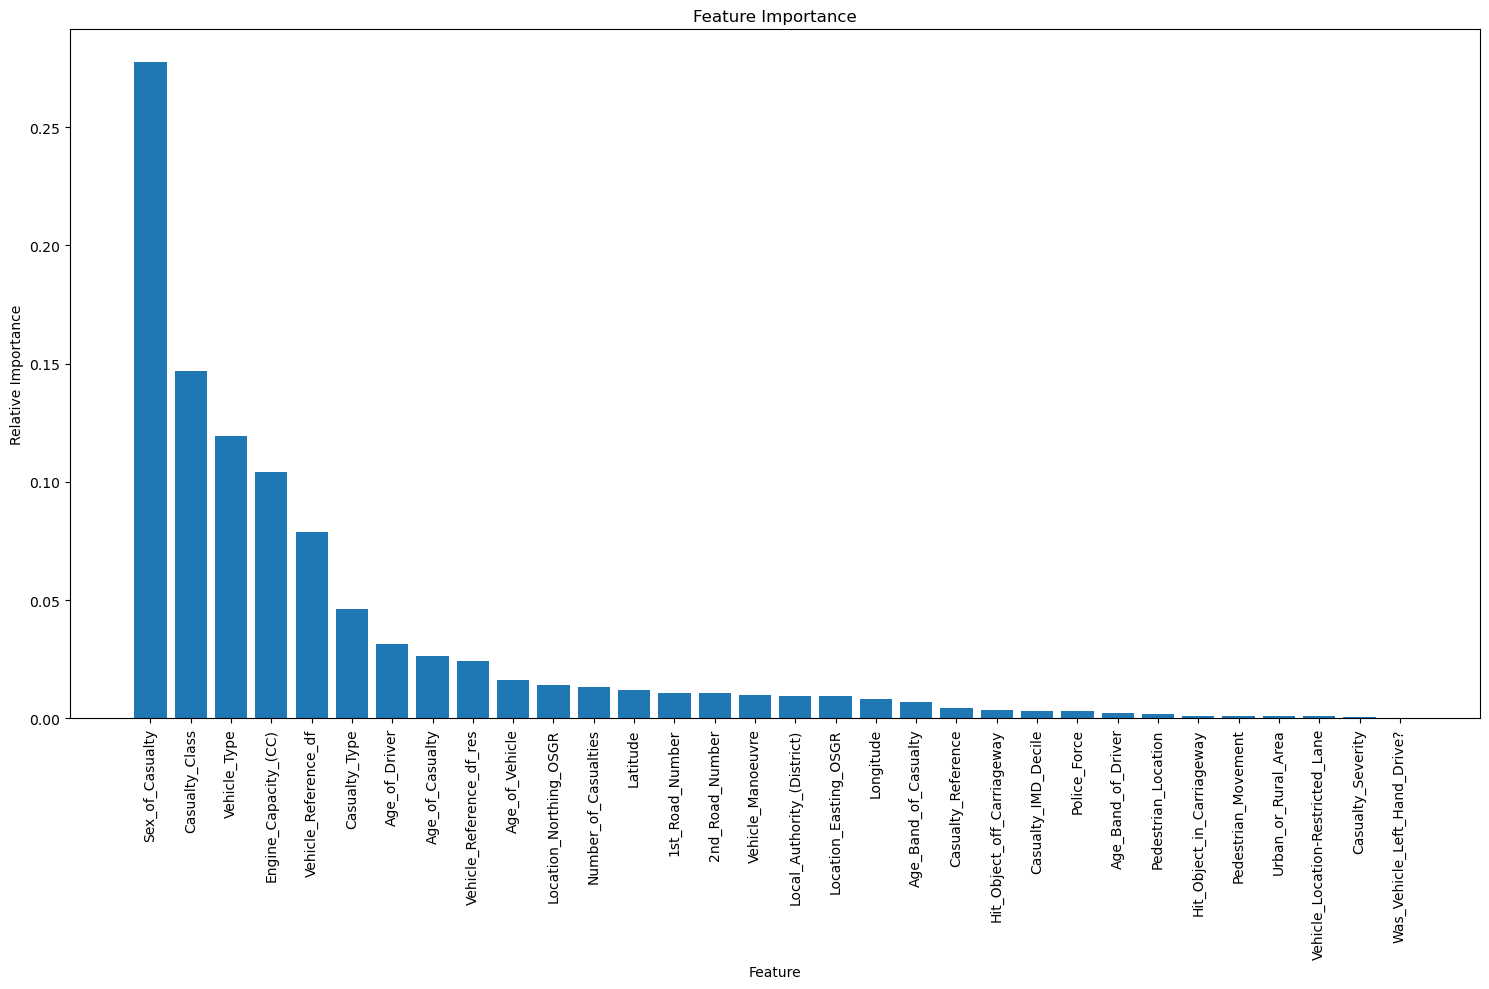

In [21]:
## TODO : display the plot
plot_explained_variance(classifier, train_X)

**TODO :** Interpret the plot.

**TODO (optional):** Try to remove the least-important features and see what happens. Does to quality improve or degrade? Why? 

* By examining the plot , we can identify which features have the most significant impact on the predictions made by the classifier. Features with higher importances (like Sex_of_Casualty, Casualty_Class, Vechile_Type, Engine_Capacity_(CC)] are considered more relevant, while those with lower importances [like Was_Vechile_Left_Hand_Drive?, Casualty_Severity, Pedestrian_Movement, Urban_or_Rural_Area, etc] appear less relevant for the given model.

## Prepare for deep learning
### Add all the necessary training functions 
*You can reuse them from previous practical exercises*

In [22]:
## TODO write a function that calculates the accuracy
## Hint - you can use yours from practical 3 

def accuracy(correct, total): 
    """
    function to calculate the accuracy given the
        correct: number of correctly classified samples
        total: total number of samples
    returns the ratio
    """
    return float(correct / total)

In [23]:
## TODO : Define a train and validation functions here
## Hint - you can use yours from practical 3 

def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """ method to train the model """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0

    for x, y in dataloader:
        optimizer.zero_grad()
        model.train()

        # Forward pass
        y_pred = model(x.to(device))
        y = y.to(device).squeeze().to(torch.int64)
        # For calculating the accuracy, save the number of correctly classified 
        # images and the total number
        epoch_correct += sum(y == y_pred.argmax(dim=1))
        epoch_total += len(y)

        # Compute loss
        loss = loss_fn(y_pred, y)

        # Backward pass
        loss.backward()
        optimizer.step()

        # For plotting the train loss, save it for each sample
        epoch_loss.append(loss.item())

    # Return the mean loss and the accuracy of this epoch
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total)


def validate(dataloader, model, loss_fn, device, master_bar):
    """ method to compute the metrics on the validation set """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0

    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            # make a prediction on validation set
            y_pred = model(x.to(device))
            y = y.to(device).squeeze().to(torch.int64)

            # For calculating the accuracy, save the number of correctly 
            # classified images and the total number
            epoch_correct += sum(y == y_pred.argmax(dim=1))
            epoch_total += len(y)

            # Compute loss
            loss = loss_fn(y_pred, y)

            # For plotting the train loss, save it for each sample
            epoch_loss.append(loss.item())

    # Return the mean loss, the accuracy and the confusion matrix
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total)

In [24]:
#TODO write a run_training function that 
# - calls the train and validate functions for each epoch
# - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
## Hint - you can use yours from practical 3 
from tqdm import trange

def run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader):
    """ method to run the training procedure """
    master_bar = trange(num_epochs)
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]

    for epoch in master_bar:
        # Train the model
        epoch_train_loss, epoch_train_acc = train(train_dataloader, optimizer, model, 
                                                  loss_function, device, master_bar)
        # Validate the model
        epoch_val_loss, epoch_val_acc = validate(val_dataloader, model, loss_function, 
                                                 device, master_bar)

        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)
        
        master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc: {epoch_val_acc:.3f}')
            
    return train_losses, val_losses, train_accs, val_accs


In [25]:
# TODO write a plot function 
## Hint - you can use yours from practical 2 or 3 
import seaborn as sns

def plot(train_metrics, validation_metrics, x, x_label, y_label, legend_names):
    fig,ax = plt.subplots(figsize=(16,12))
    df = pd.DataFrame(zip(x, train_metrics, [legend_names[0]] * len(train_metrics)), columns=[x_label, y_label, "type"])
    df = pd.concat([df, pd.DataFrame(zip(x, validation_metrics, [legend_names[1]] * len(train_metrics)), columns=[x_label, y_label, "type" ])])
    ax = sns.pointplot(data=df, x=x_label, y=y_label, hue='type', linestyles=['--', '--'], ax=ax)
    plt.plot()

### Convert a pandas dataframe to a PyTorch dataset

In [26]:
## TODO : Define the dataset, apply normalization in the getitem method
## Hint : you can use/adapt your code from practical 2
class TabularDataset(torch.utils.data.Dataset):
    def __init__(self, df_x, df_y, mean=None, std=None, normalise=True):
        '''
        TODO: save params to self attributes, 
        x is data without target column
        y is target column
        transform df to_numpy
        ''' 
        self.x = df_x.to_numpy()
        self.y = df_y.to_numpy().reshape(-1,1)
        self.mean = mean
        self.std = std
        self.normalise = normalise

    
    def __len__(self):
        # TODO: return whole dataset length
        return len(self.x)
    
    def __getitem__(self, index):
        data = self.x[index]
        if self.normalise and self.mean is not None and self.std is not None:
            data = (data - self.mean) / self.std
        return data, self.y[index]

In [27]:
## TODO : calculate mean and std for the train set
## Hint : be careful with categorical values. Convert them them to numerical 
## Hint : the response variable should be of datatype integer
cat_columns = X.select_dtypes(['category']).columns
new_X = X.copy()
new_X[cat_columns] = new_X[cat_columns].apply(lambda x: x.cat.codes)
new_Y = df[target_column].astype('category').cat.codes
train_X, test_X, train_y, test_y = train_test_split(new_X, new_Y, test_size=test_size, random_state=random_state)

tmp_dataset = TabularDataset(train_X, train_y, normalise=False)
mean = tmp_dataset.x.mean(axis=0)
std = tmp_dataset.x.std(axis=0)

In [28]:
# TODO : define new datasets with mean, std and normalise=True
# be careful with the labels, they should start from 0!
train_X_new =  TabularDataset(train_X, train_y, mean, std, normalise=True)
test_X_new =  TabularDataset(test_X, test_y, mean, std, normalise=True)
## TODO : define dataloaders, with specified batch size and shuffled
batch_size = 256
train_dataloader =  DataLoader(train_X_new, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_X_new, batch_size=batch_size, shuffle=True)

## Logistic regression

In [29]:
class LR(torch.nn.Module):
    """
    The logistic regression model inherits from torch.nn.Module 
    which is the base class for all neural network modules.
    """
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(LR, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        

    def forward(self, x):
        """ Defines the computation performed at every call. """
        # What are the dimensions of your input layer?
        x = x.to(torch.float32)
        # TODO run the data through the layer
        outputs = self.linear(x)
        return outputs

In [30]:
## TODO define model, loss and optimisers
## don't forget to move everything for the correct devices
## 
lr=0.001
input_dim, output_dim = train_X_new.x.shape[1], len(np.unique(train_X_new.y))

print(f"Input Dimension: {input_dim}, Output Dimension: {output_dim}")

logistic_regression = LR(input_dim, output_dim)
logistic_regression = logistic_regression.to(device)
logistic_regression.train()

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(logistic_regression.parameters(), lr=lr)

Input Dimension: 32, Output Dimension: 3


In [31]:
## TODO train the network
num_epochs = 30
train_losses_lr, val_losses_lr, train_accs_lr, val_accs_lr = run_training(model=logistic_regression, 
                                                                          optimizer=optimizer, 
                                                                          loss_function=loss_function, 
                                                                          device=device, 
                                                                          num_epochs=num_epochs, 
                                                                          train_dataloader=train_dataloader, 
                                                                          val_dataloader=test_dataloader)

  3%|▎         | 1/30 [00:05<02:38,  5.47s/it]

Train loss: 0.90, val loss: 0.79, train acc: 0.652, val acc: 0.734


  7%|▋         | 2/30 [00:08<01:55,  4.13s/it]

Train loss: 0.75, val loss: 0.70, train acc: 0.727, val acc: 0.738


 10%|█         | 3/30 [00:11<01:32,  3.44s/it]

Train loss: 0.69, val loss: 0.66, train acc: 0.735, val acc: 0.745


 13%|█▎        | 4/30 [00:13<01:22,  3.16s/it]

Train loss: 0.65, val loss: 0.63, train acc: 0.742, val acc: 0.751


 17%|█▋        | 5/30 [00:16<01:14,  2.98s/it]

Train loss: 0.63, val loss: 0.61, train acc: 0.746, val acc: 0.751


 20%|██        | 6/30 [00:19<01:08,  2.87s/it]

Train loss: 0.61, val loss: 0.60, train acc: 0.748, val acc: 0.754


 23%|██▎       | 7/30 [00:21<01:04,  2.80s/it]

Train loss: 0.60, val loss: 0.59, train acc: 0.749, val acc: 0.755


 27%|██▋       | 8/30 [00:24<01:01,  2.80s/it]

Train loss: 0.59, val loss: 0.58, train acc: 0.750, val acc: 0.756


 30%|███       | 9/30 [00:27<00:58,  2.79s/it]

Train loss: 0.58, val loss: 0.57, train acc: 0.752, val acc: 0.757


 33%|███▎      | 10/30 [00:30<00:55,  2.78s/it]

Train loss: 0.58, val loss: 0.57, train acc: 0.751, val acc: 0.757


 37%|███▋      | 11/30 [00:33<00:56,  2.97s/it]

Train loss: 0.58, val loss: 0.57, train acc: 0.751, val acc: 0.758


 40%|████      | 12/30 [00:36<00:53,  2.95s/it]

Train loss: 0.57, val loss: 0.56, train acc: 0.752, val acc: 0.758


 43%|████▎     | 13/30 [00:39<00:49,  2.91s/it]

Train loss: 0.57, val loss: 0.56, train acc: 0.751, val acc: 0.759


 47%|████▋     | 14/30 [00:42<00:46,  2.89s/it]

Train loss: 0.57, val loss: 0.56, train acc: 0.752, val acc: 0.757


 50%|█████     | 15/30 [00:45<00:43,  2.89s/it]

Train loss: 0.57, val loss: 0.56, train acc: 0.752, val acc: 0.760


 53%|█████▎    | 16/30 [00:48<00:40,  2.89s/it]

Train loss: 0.57, val loss: 0.56, train acc: 0.752, val acc: 0.758


 57%|█████▋    | 17/30 [00:50<00:37,  2.85s/it]

Train loss: 0.56, val loss: 0.56, train acc: 0.752, val acc: 0.756


 60%|██████    | 18/30 [00:53<00:33,  2.83s/it]

Train loss: 0.56, val loss: 0.56, train acc: 0.752, val acc: 0.759


 63%|██████▎   | 19/30 [00:56<00:31,  2.84s/it]

Train loss: 0.56, val loss: 0.56, train acc: 0.753, val acc: 0.760


 67%|██████▋   | 20/30 [00:59<00:28,  2.87s/it]

Train loss: 0.56, val loss: 0.55, train acc: 0.753, val acc: 0.759


 70%|███████   | 21/30 [01:02<00:25,  2.86s/it]

Train loss: 0.56, val loss: 0.55, train acc: 0.753, val acc: 0.759


 73%|███████▎  | 22/30 [01:05<00:24,  3.04s/it]

Train loss: 0.56, val loss: 0.55, train acc: 0.753, val acc: 0.760


 77%|███████▋  | 23/30 [01:08<00:20,  2.97s/it]

Train loss: 0.56, val loss: 0.55, train acc: 0.752, val acc: 0.758


 80%|████████  | 24/30 [01:11<00:17,  2.89s/it]

Train loss: 0.56, val loss: 0.55, train acc: 0.753, val acc: 0.759


 83%|████████▎ | 25/30 [01:13<00:14,  2.83s/it]

Train loss: 0.56, val loss: 0.55, train acc: 0.752, val acc: 0.757


 87%|████████▋ | 26/30 [01:16<00:11,  2.79s/it]

Train loss: 0.56, val loss: 0.55, train acc: 0.752, val acc: 0.757


 90%|█████████ | 27/30 [01:19<00:08,  2.78s/it]

Train loss: 0.56, val loss: 0.55, train acc: 0.753, val acc: 0.756


 93%|█████████▎| 28/30 [01:22<00:05,  2.75s/it]

Train loss: 0.56, val loss: 0.55, train acc: 0.752, val acc: 0.758


 97%|█████████▋| 29/30 [01:24<00:02,  2.74s/it]

Train loss: 0.56, val loss: 0.55, train acc: 0.753, val acc: 0.759


100%|██████████| 30/30 [01:27<00:00,  2.92s/it]

Train loss: 0.56, val loss: 0.55, train acc: 0.752, val acc: 0.760


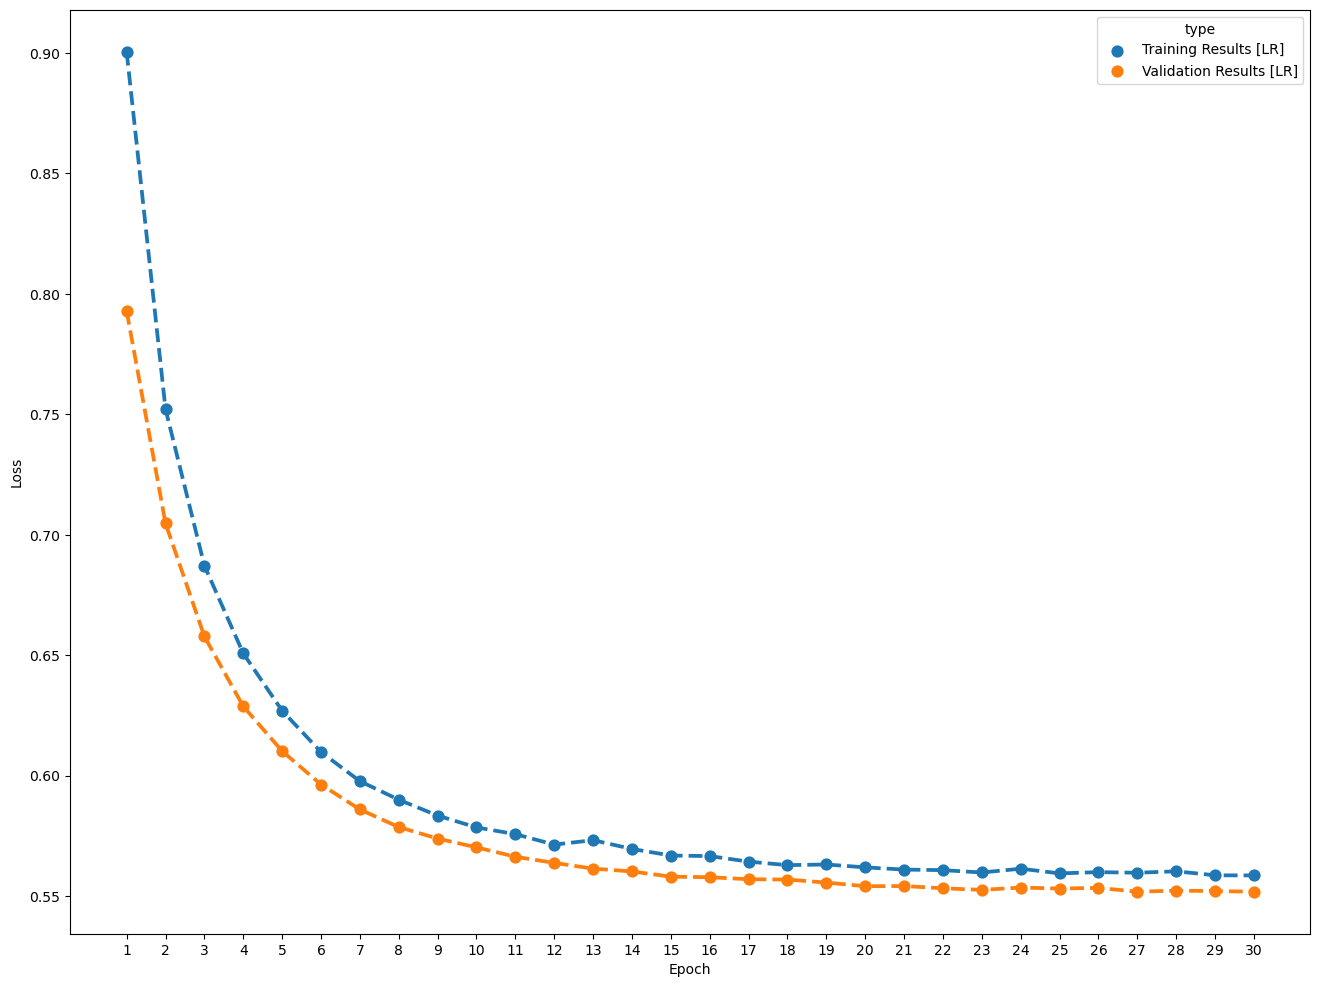

In [32]:
## todo - plot losses and accuracies
plot(train_losses_lr, val_losses_lr, range(1, num_epochs+1), "Epoch", "Loss", ['Training Results [LR]', 'Validation Results [LR]'])

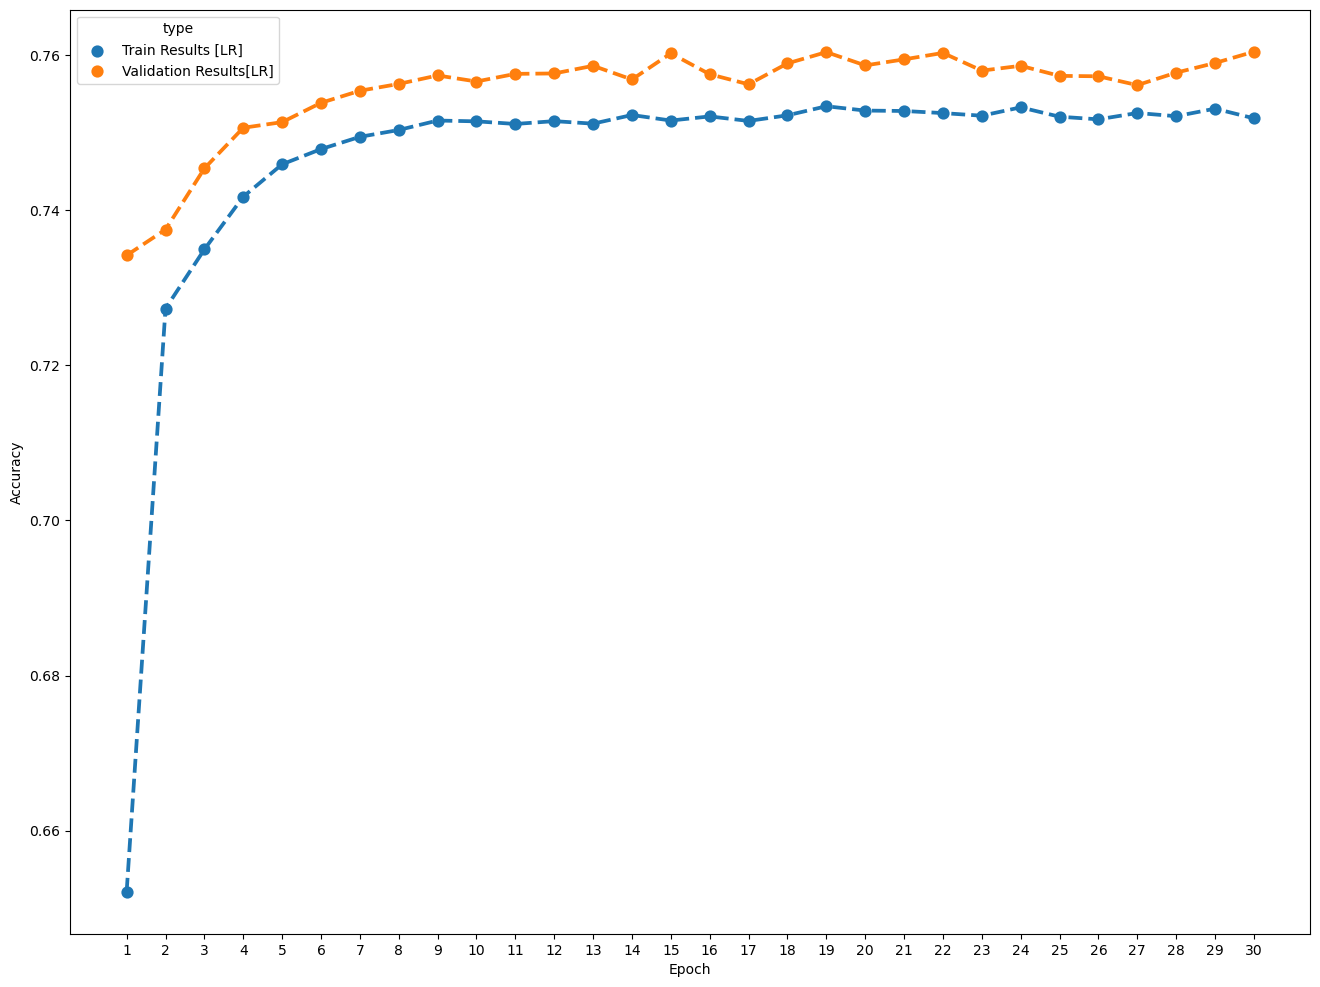

In [33]:
plot(train_accs_lr, val_accs_lr, range(1, num_epochs+1), "Epoch", "Accuracy", ['Train Results [LR]', 'Validation Results[LR]'])


## Create a simple MLP

As the default tree has 3 layers, let's make a MLP with 3 linear layers and ReLU.
Please notice that making convolutions on tabular data does not make much sense even though it is technically possible.   

**TODO :** Explain why making convolutions on tabular data does not make much sense. Why do we use an MLP, not a CNN from the previous homework?

* Convolutional Neural Networks (CNNs) use convolutions to extract features from grid-like data like images, capturing spatial relationships. However, applying convolutions to tabular data, which lacks a spatial structure, is not suitable. Tabular data has a different structure and does not possess the same local spatial relationships as images. Additionally, convolutions assume translation invariance, which may not hold for tabular data where feature order and position matter. Tabular data is typically represented as a 2D matrix, and reshaping it for convolutions would be artificial. Multilayer Perceptron (MLP) architectures, with fully connected layers, are more appropriate for tabular data, as they can capture complex feature interactions and handle variable-length inputs. MLPs are flexible, adaptable, and commonly used for modeling tabular data.

In [34]:
class TabularNetwork(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(TabularNetwork, self).__init__()
        self.network = nn.Sequential(
            # TODO : define 3 linear layer with sizes 
            # input_dim -> input_dim // 2 -> output_dim
            # using ReLU as nonlinearity
            nn.Linear(input_dim, input_dim // 2),
            nn.ReLU(),
            nn.Linear(input_dim // 2, output_dim),
            nn.ReLU(),
            nn.Linear(output_dim, output_dim),
            nn.ReLU(),
        )
      

    def forward(self, x):
        """ Defines the computation performed at every call. """
        # TODO
        x = x.to(torch.float32)
        outputs = self.network(x)
        return outputs

In [35]:
## TODO : define model, optimiser, cross entropy loss,
## put model to the device, and train mode
## you can optionally apply regularisation between 0.0005 and 0.005 
lr=0.001

tabular_network = TabularNetwork(input_dim, output_dim)
tabular_network = tabular_network.to(device)
tabular_network.train()

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(tabular_network.parameters(), lr=lr, weight_decay=0.0005)

In [36]:
## TODO : Train model
num_epochs = 50
train_losses_lr, val_losses_lr, train_accs_lr, val_accs_lr = run_training(model=tabular_network, 
                                                                          optimizer=optimizer, 
                                                                          loss_function=loss_function, 
                                                                          device=device, 
                                                                          num_epochs=num_epochs, 
                                                                          train_dataloader=train_dataloader, 
                                                                          val_dataloader=test_dataloader)

  2%|▏         | 1/50 [00:03<02:28,  3.03s/it]

Train loss: 0.97, val loss: 0.95, train acc: 0.655, val acc: 0.652


  4%|▍         | 2/50 [00:06<02:30,  3.14s/it]

Train loss: 0.92, val loss: 0.91, train acc: 0.656, val acc: 0.652


  6%|▌         | 3/50 [00:09<02:25,  3.09s/it]

Train loss: 0.90, val loss: 0.87, train acc: 0.656, val acc: 0.652


  8%|▊         | 4/50 [00:12<02:21,  3.08s/it]

Train loss: 0.81, val loss: 0.69, train acc: 0.692, val acc: 0.771


 10%|█         | 5/50 [00:15<02:14,  3.00s/it]

Train loss: 0.61, val loss: 0.51, train acc: 0.775, val acc: 0.787


 12%|█▏        | 6/50 [00:18<02:09,  2.95s/it]

Train loss: 0.47, val loss: 0.44, train acc: 0.785, val acc: 0.791


 14%|█▍        | 7/50 [00:20<02:05,  2.91s/it]

Train loss: 0.44, val loss: 0.43, train acc: 0.788, val acc: 0.794


 16%|█▌        | 8/50 [00:23<02:03,  2.93s/it]

Train loss: 0.42, val loss: 0.41, train acc: 0.792, val acc: 0.798


 18%|█▊        | 9/50 [00:26<01:59,  2.91s/it]

Train loss: 0.42, val loss: 0.41, train acc: 0.795, val acc: 0.799


 20%|██        | 10/50 [00:29<01:55,  2.89s/it]

Train loss: 0.41, val loss: 0.40, train acc: 0.797, val acc: 0.799


 22%|██▏       | 11/50 [00:32<01:51,  2.87s/it]

Train loss: 0.40, val loss: 0.40, train acc: 0.799, val acc: 0.800


 24%|██▍       | 12/50 [00:35<01:50,  2.91s/it]

Train loss: 0.40, val loss: 0.39, train acc: 0.800, val acc: 0.800


 26%|██▌       | 13/50 [00:38<01:54,  3.09s/it]

Train loss: 0.39, val loss: 0.39, train acc: 0.800, val acc: 0.801


 28%|██▊       | 14/50 [00:41<01:48,  3.03s/it]

Train loss: 0.39, val loss: 0.39, train acc: 0.802, val acc: 0.799


 30%|███       | 15/50 [00:44<01:45,  3.01s/it]

Train loss: 0.39, val loss: 0.39, train acc: 0.802, val acc: 0.801


 32%|███▏      | 16/50 [00:47<01:41,  3.00s/it]

Train loss: 0.39, val loss: 0.38, train acc: 0.802, val acc: 0.801


 34%|███▍      | 17/50 [00:50<01:37,  2.97s/it]

Train loss: 0.39, val loss: 0.38, train acc: 0.803, val acc: 0.800


 36%|███▌      | 18/50 [00:53<01:34,  2.94s/it]

Train loss: 0.39, val loss: 0.38, train acc: 0.803, val acc: 0.804


 38%|███▊      | 19/50 [00:56<01:31,  2.96s/it]

Train loss: 0.39, val loss: 0.38, train acc: 0.804, val acc: 0.804


 40%|████      | 20/50 [00:59<01:28,  2.95s/it]

Train loss: 0.39, val loss: 0.38, train acc: 0.804, val acc: 0.801


 42%|████▏     | 21/50 [01:02<01:25,  2.93s/it]

Train loss: 0.38, val loss: 0.38, train acc: 0.803, val acc: 0.804


 44%|████▍     | 22/50 [01:05<01:21,  2.92s/it]

Train loss: 0.38, val loss: 0.38, train acc: 0.804, val acc: 0.804


 46%|████▌     | 23/50 [01:08<01:19,  2.95s/it]

Train loss: 0.38, val loss: 0.38, train acc: 0.805, val acc: 0.803


 48%|████▊     | 24/50 [01:11<01:20,  3.11s/it]

Train loss: 0.38, val loss: 0.38, train acc: 0.804, val acc: 0.803


 50%|█████     | 25/50 [01:14<01:16,  3.05s/it]

Train loss: 0.38, val loss: 0.38, train acc: 0.805, val acc: 0.803


 52%|█████▏    | 26/50 [01:17<01:12,  3.02s/it]

Train loss: 0.38, val loss: 0.38, train acc: 0.805, val acc: 0.803


 54%|█████▍    | 27/50 [01:20<01:08,  2.99s/it]

Train loss: 0.38, val loss: 0.38, train acc: 0.804, val acc: 0.805


 56%|█████▌    | 28/50 [01:23<01:05,  2.97s/it]

Train loss: 0.38, val loss: 0.37, train acc: 0.805, val acc: 0.805


 58%|█████▊    | 29/50 [01:26<01:02,  2.97s/it]

Train loss: 0.38, val loss: 0.37, train acc: 0.805, val acc: 0.805


 60%|██████    | 30/50 [01:29<00:59,  2.99s/it]

Train loss: 0.38, val loss: 0.37, train acc: 0.805, val acc: 0.804


 62%|██████▏   | 31/50 [01:32<00:56,  2.95s/it]

Train loss: 0.38, val loss: 0.37, train acc: 0.806, val acc: 0.804


 64%|██████▍   | 32/50 [01:35<00:53,  2.95s/it]

Train loss: 0.38, val loss: 0.38, train acc: 0.806, val acc: 0.805


 66%|██████▌   | 33/50 [01:38<00:50,  2.95s/it]

Train loss: 0.38, val loss: 0.37, train acc: 0.806, val acc: 0.805


 68%|██████▊   | 34/50 [01:41<00:49,  3.06s/it]

Train loss: 0.37, val loss: 0.37, train acc: 0.806, val acc: 0.805


 70%|███████   | 35/50 [01:44<00:46,  3.09s/it]

Train loss: 0.38, val loss: 0.37, train acc: 0.806, val acc: 0.806


 72%|███████▏  | 36/50 [01:47<00:42,  3.03s/it]

Train loss: 0.38, val loss: 0.37, train acc: 0.807, val acc: 0.805


 74%|███████▍  | 37/50 [01:50<00:39,  3.03s/it]

Train loss: 0.37, val loss: 0.37, train acc: 0.807, val acc: 0.804


 76%|███████▌  | 38/50 [01:53<00:36,  3.00s/it]

Train loss: 0.37, val loss: 0.37, train acc: 0.807, val acc: 0.802


 78%|███████▊  | 39/50 [01:56<00:32,  2.96s/it]

Train loss: 0.37, val loss: 0.37, train acc: 0.807, val acc: 0.806


 80%|████████  | 40/50 [01:59<00:29,  2.94s/it]

Train loss: 0.37, val loss: 0.37, train acc: 0.807, val acc: 0.806


 82%|████████▏ | 41/50 [02:02<00:26,  2.94s/it]

Train loss: 0.37, val loss: 0.37, train acc: 0.807, val acc: 0.805


 84%|████████▍ | 42/50 [02:05<00:23,  2.91s/it]

Train loss: 0.37, val loss: 0.37, train acc: 0.807, val acc: 0.805


 86%|████████▌ | 43/50 [02:07<00:20,  2.91s/it]

Train loss: 0.37, val loss: 0.37, train acc: 0.807, val acc: 0.806


 88%|████████▊ | 44/50 [02:10<00:17,  2.88s/it]

Train loss: 0.37, val loss: 0.37, train acc: 0.807, val acc: 0.806


 90%|█████████ | 45/50 [02:14<00:15,  3.09s/it]

Train loss: 0.37, val loss: 0.37, train acc: 0.808, val acc: 0.805


 92%|█████████▏| 46/50 [02:17<00:12,  3.01s/it]

Train loss: 0.37, val loss: 0.37, train acc: 0.807, val acc: 0.807


 94%|█████████▍| 47/50 [02:20<00:08,  2.96s/it]

Train loss: 0.37, val loss: 0.37, train acc: 0.808, val acc: 0.807


 96%|█████████▌| 48/50 [02:22<00:05,  2.94s/it]

Train loss: 0.37, val loss: 0.37, train acc: 0.808, val acc: 0.807


 98%|█████████▊| 49/50 [02:25<00:02,  2.94s/it]

Train loss: 0.37, val loss: 0.37, train acc: 0.809, val acc: 0.805


100%|██████████| 50/50 [02:28<00:00,  2.97s/it]

Train loss: 0.37, val loss: 0.37, train acc: 0.808, val acc: 0.808


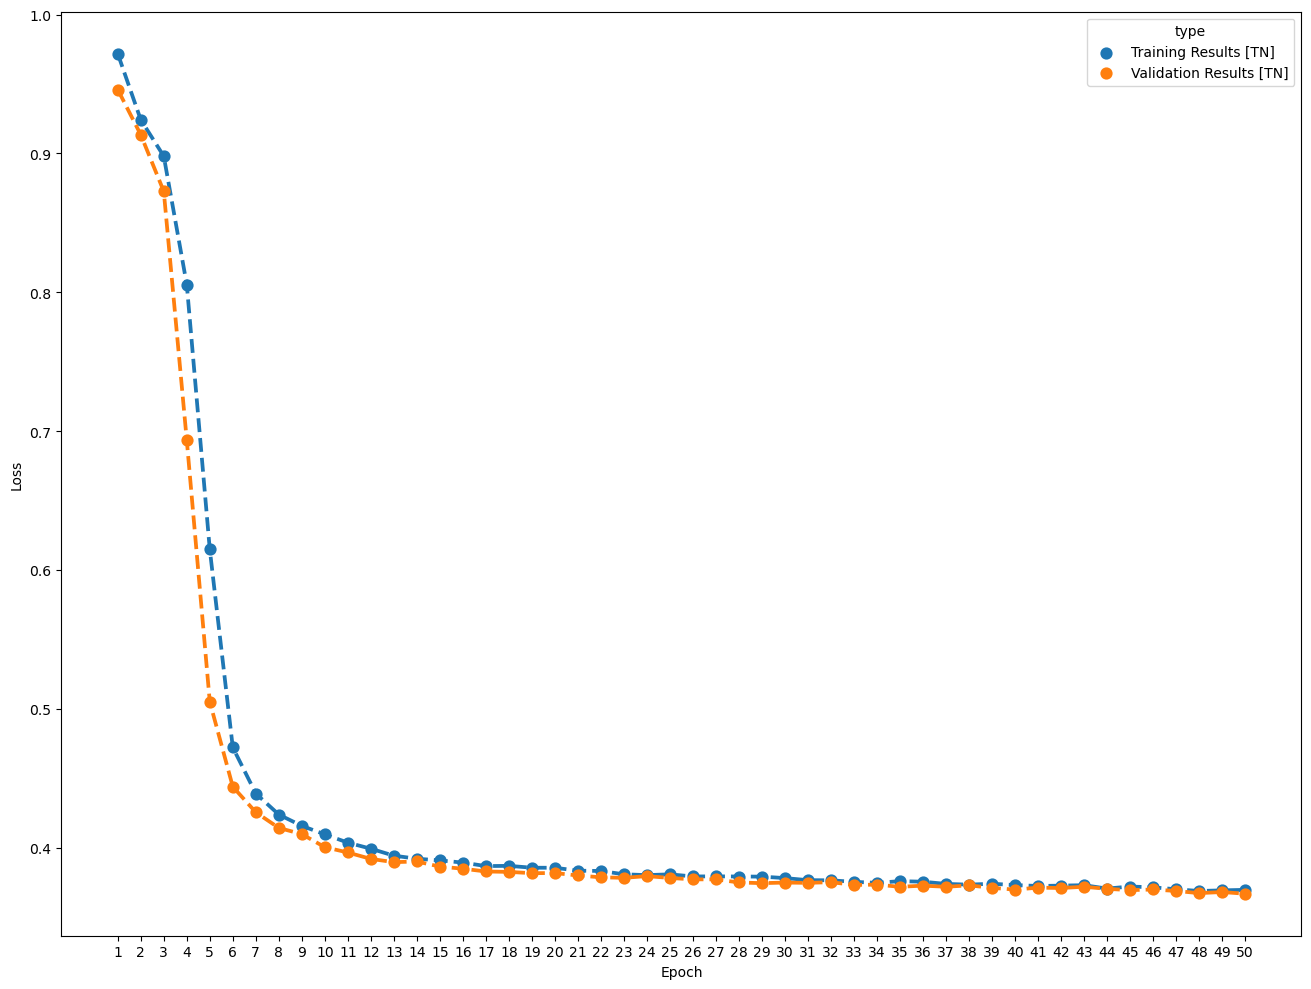

In [37]:
# TODO plot losses
plot(train_losses_lr, val_losses_lr, range(1, num_epochs+1), "Epoch", "Loss", ['Training Results [TN]', 'Validation Results [TN]'])

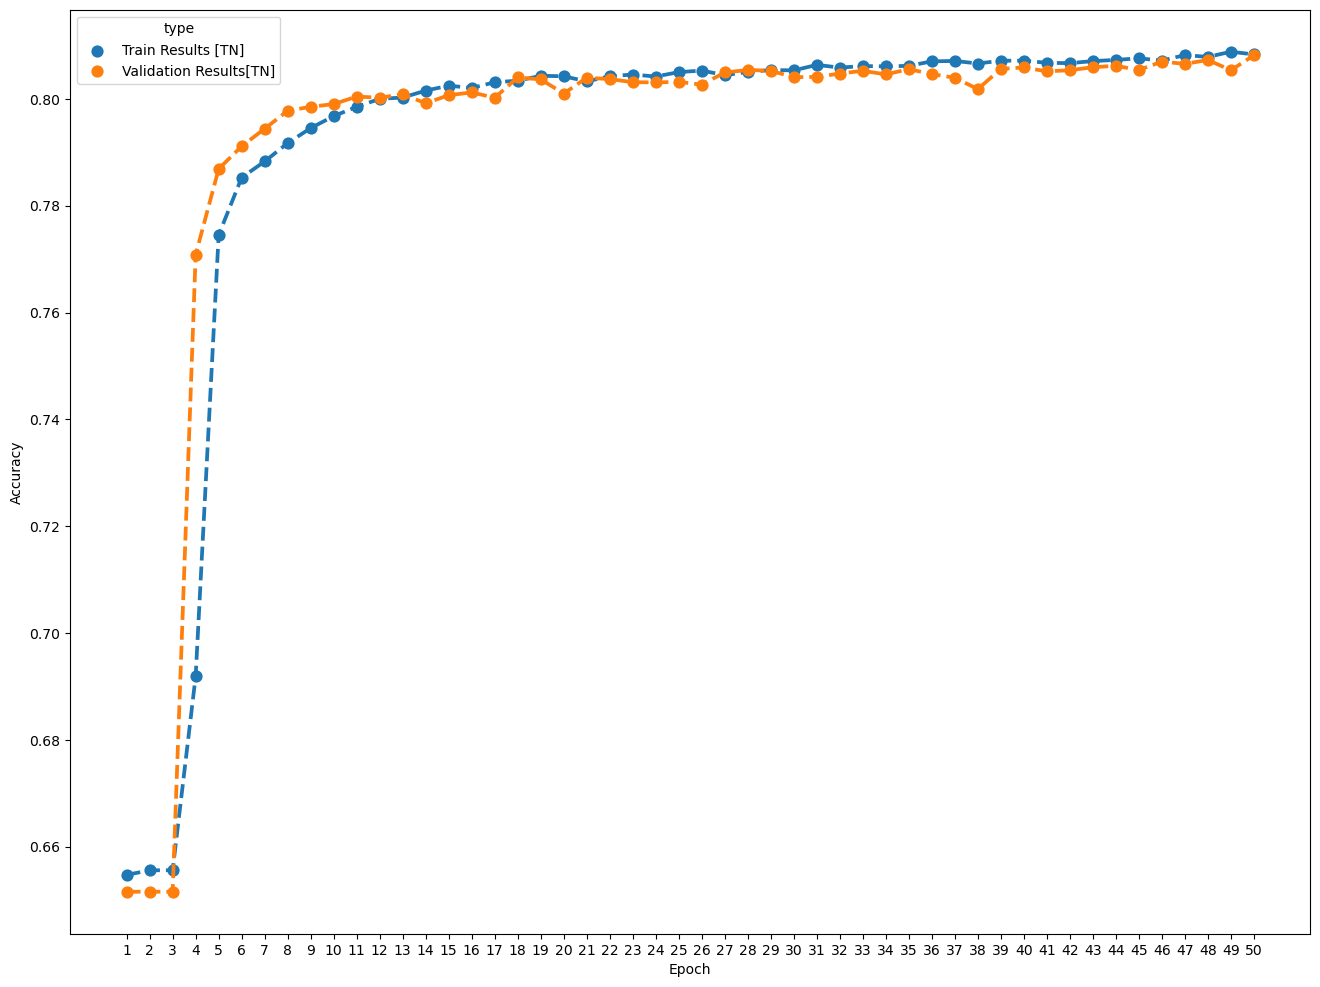

In [38]:
# TODO plot accuracies
plot(train_accs_lr, val_accs_lr, range(1, num_epochs+1), "Epoch", "Accuracy", ['Train Results [TN]', 'Validation Results[TN]'])

**TODO:** Did your network perform better or worse than the GradientBoostingClassifier on this dataset? Why? 


In our implementation, MLP is performing better compared to GradientBoostingClassifier on average. In general, Multilayer Perceptron (MLP) models may perform better on tabular data compared to Gradient Boosting Classifiers  due to their flexibility in capturing non-linear relationships, ability to handle both continuous and categorical features, effectiveness in handling imbalanced datasets, and capability for end-to-end learning without extensive feature engineering. MLPs excel in capturing complex patterns [Universal Approximator Theorem] and interactions within tabular data, providing a powerful approach for modeling such datasets. However, the performance of specific models ultimately depends on the characteristics of the dataset, the quality of features, and thorough evaluation and experimentation.

## Bonus tasks (optional)
* Try to use SGD instead of Adam as optimiser. What do you notice?
Here are different opinions on this topic:
  * https://codeahoy.com/questions/ds-interview/33/#:~:text=Adam%20tends%20to%20converge%20faster,converges%20to%20more%20optimal%20solutions.
  * https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/ 
  * https://datascience.stackexchange.com/questions/30344/why-not-always-use-the-adam-optimization-technique

* Try to make your MLP twice deeper. What do you notice? Why?

## Advanced topic to read about:
**Tools which may be helpful for data exploration:**
* df.describe() - returns some basic statistics for your dataset - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html
* ydata-profiling (previous pandas-profiling) - generates interactive data exploration report: basic statistics, nans, correlations between different features - https://github.com/ydataai/ydata-profiling

**Tree libraries**
* XGBoost - XGBoost stands for “Extreme Gradient Boosting”, where the term “Gradient Boosting” originates from the paper Greedy Function Approximation: A Gradient Boosting Machine, by Friedman. https://xgboost.readthedocs.io/en/stable/tutorials/model.html
* LightGBM - industrial library for XGBoost from Miscrosoft. LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient. https://lightgbm.readthedocs.io/en/v3.3.2/